In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [4]:
data = '/content/drive/MyDrive/Tesis/Final Dataset/Final Dataset.xlsx'
data = pd.read_excel(data)

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index of the DataFrame
data.set_index('Date', inplace=True)

In [6]:
print(data.head(30))

           Ticker  Close Price   Volume   PE Ratio  Weekly Return  \
Date                                                                
2019-04-29    A.N        79.29   359454  22.104515       0.024154   
2019-05-06    A.N        77.10   583792  21.493985      -0.027620   
2019-05-13    A.N        69.11   690865  19.266528      -0.103632   
2019-05-20    A.N        68.36   791693  19.057443      -0.010852   
2019-05-27    A.N        67.05   626576  19.020197      -0.019163   
2019-06-03    A.N        69.52   387285  19.720867       0.036838   
2019-06-10    A.N        69.97   454132  19.848519       0.006473   
2019-06-17    A.N        73.34  1230086  20.804493       0.048163   
2019-06-24    A.N        74.67  1259133  21.181777       0.018135   
2019-07-01    A.N        75.75   307603  21.488143       0.014464   
2019-07-08    A.N        71.65   661104  20.325088      -0.054125   
2019-07-15    A.N        68.70   564934  19.488256      -0.041172   
2019-07-22    A.N        69.50   4

In [7]:
data['Differential Return'] = data['Weekly Return'] - data['Weekly Return_SPY']

data.head()

,Ticker,Close Price,Volume,PE Ratio,Weekly Return,Weekly Return_SPY,Differential Return
Date,,,,,,,
2019-04-29,A.N,79.29,359454,22.104515,0.024154,0.002113,0.022041
2019-05-06,A.N,77.10,583792,21.493985,-0.027620,-0.020168,-0.007452
2019-05-13,A.N,69.11,690865,19.266528,-0.103632,-0.007844,-0.095787
2019-05-20,A.N,68.36,791693,19.057443,-0.010852,-0.010705,-0.000147
2019-05-27,A.N,67.05,626576,19.020197,-0.019163,-0.026558,0.007394


In [8]:
# Calculate Rolling Tracking Error
data['Rolling Tracking Error'] = data.groupby('Ticker')['Differential Return'].transform(lambda x: x.rolling(window=4).std())

# Forward-fill NaN values in 'Rolling Tracking Error'
data['Rolling Tracking Error'] = data.groupby('Ticker')['Rolling Tracking Error'].fillna(method='bfill')

# Display the first few rows to verify the calculation and forward filling
print(data.head(50))


           Ticker  Close Price   Volume   PE Ratio  Weekly Return  \
Date                                                                
2019-04-29    A.N        79.29   359454  22.104515       0.024154   
2019-05-06    A.N        77.10   583792  21.493985      -0.027620   
2019-05-13    A.N        69.11   690865  19.266528      -0.103632   
2019-05-20    A.N        68.36   791693  19.057443      -0.010852   
2019-05-27    A.N        67.05   626576  19.020197      -0.019163   
2019-06-03    A.N        69.52   387285  19.720867       0.036838   
2019-06-10    A.N        69.97   454132  19.848519       0.006473   
2019-06-17    A.N        73.34  1230086  20.804493       0.048163   
2019-06-24    A.N        74.67  1259133  21.181777       0.018135   
2019-07-01    A.N        75.75   307603  21.488143       0.014464   
2019-07-08    A.N        71.65   661104  20.325088      -0.054125   
2019-07-15    A.N        68.70   564934  19.488256      -0.041172   
2019-07-22    A.N        69.50   4

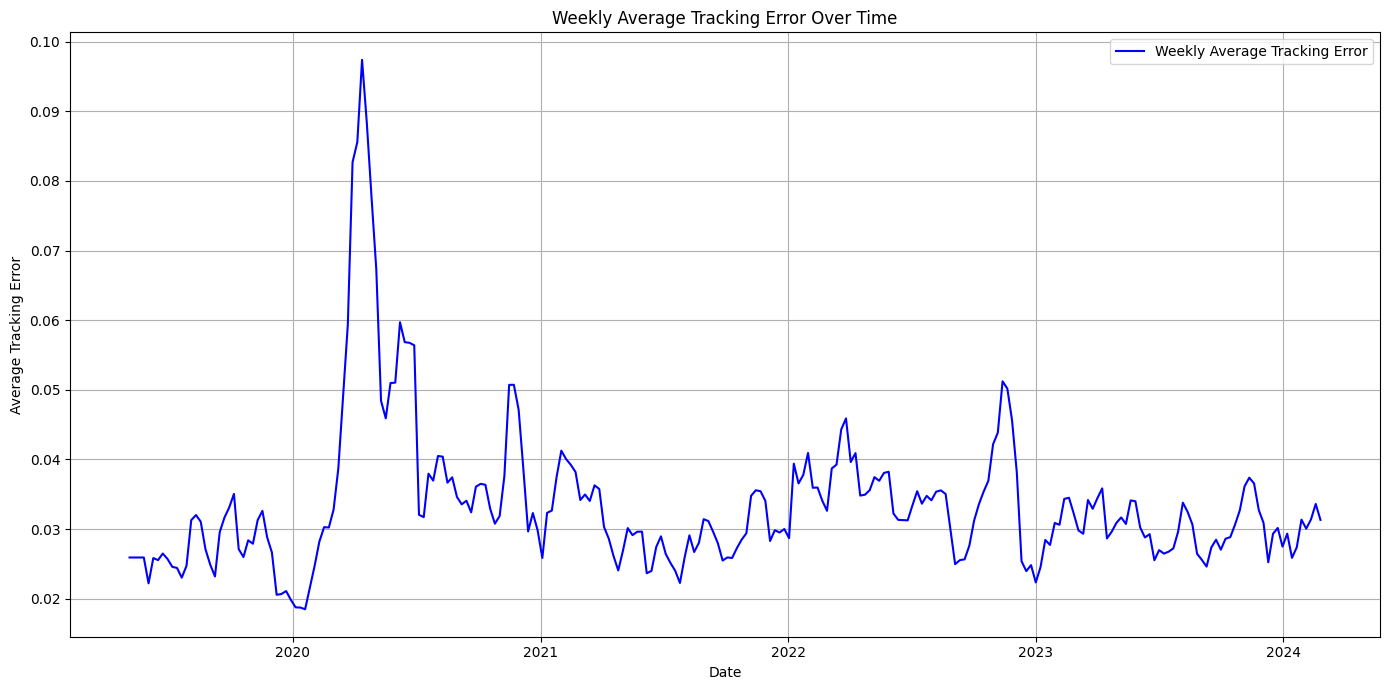

In [9]:
# Resample to weekly frequency, calculating the mean of 'Rolling Tracking Error' for each week
weekly_avg_tracking_error = data['Rolling Tracking Error'].resample('W').mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(weekly_avg_tracking_error.index, weekly_avg_tracking_error, label='Weekly Average Tracking Error', color='blue')


plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Date')
plt.ylabel('Average Tracking Error')
plt.title('Weekly Average Tracking Error Over Time')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()



In [10]:
# 1-week lagged return
data['Lagged_1W_Return'] = data.groupby('Ticker')['Weekly Return'].shift(1)

# 4-week lagged return
data['Lagged_4W_Return'] = data.groupby('Ticker')['Weekly Return'].shift(4)

In [11]:
# Historical Volatility calculation over a 4-week rolling window
log_returns = np.log(data['Close Price'] / data['Close Price'].shift(1))
data['Historical_Volatility_4w'] = log_returns.rolling(window=4).std() * np.sqrt(52)  # Annualized

# Calculate RSI
def calculate_rsi(data, column='Close Price', periods=[2, 4, 12]):
    for period in periods:
        delta = data[column].diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))

        # Adding RSI to the DataFrame
        data[f'RSI_{period}w'] = rsi

# Calculate RSI for 2, 4, and 12 weeks
calculate_rsi(data)

# Checking the calculations
print(data[['Historical_Volatility_4w', 'RSI_2w', 'RSI_4w', 'RSI_12w']].head(20))

            Historical_Volatility_4w      RSI_2w      RSI_4w    RSI_12w
Date                                                                   
2019-04-29                       NaN         NaN         NaN        NaN
2019-05-06                       NaN    0.000000         NaN        NaN
2019-05-13                       NaN    0.000000         NaN        NaN
2019-05-20                       NaN    0.000000    0.000000        NaN
2019-05-27                  0.328311    0.000000    0.000000        NaN
2019-06-03                  0.438513   65.343915   19.728435        NaN
2019-06-10                  0.176907  100.000000   58.634538        NaN
2019-06-17                  0.216384  100.000000   82.763158        NaN
2019-06-24                  0.130961  100.000000  100.000000        NaN
2019-07-01                  0.127790  100.000000  100.000000        NaN
2019-07-08                  0.314258   20.849421   58.502024        NaN
2019-07-15                  0.273814    0.000000   25.475687  31

In [12]:
cleaned_data = data.groupby('Ticker', as_index=False)

In [13]:
cleaned_data.head()

,Ticker,Close Price,Volume,PE Ratio,Weekly Return,Weekly Return_SPY,Differential Return,Rolling Tracking Error,Lagged_1W_Return,Lagged_4W_Return,Historical_Volatility_4w,RSI_2w,RSI_4w,RSI_12w
Date,,,,,,,,,,,,,,
2019-04-29,A.N,79.29,359454,22.104515,0.024154,0.002113,0.022041,0.051840,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-06,A.N,77.10,583792,21.493985,-0.027620,-0.020168,-0.007452,0.051840,0.024154,NaN,NaN,0.000000,NaN,NaN
2019-05-13,A.N,69.11,690865,19.266528,-0.103632,-0.007844,-0.095787,0.051840,-0.027620,NaN,NaN,0.000000,NaN,NaN
2019-05-20,A.N,68.36,791693,19.057443,-0.010852,-0.010705,-0.000147,0.051840,-0.103632,NaN,NaN,0.000000,0.000000,NaN
2019-05-27,A.N,67.05,626576,19.020197,-0.019163,-0.026558,0.007394,0.048242,-0.010852,0.024154,0.328311,0.000000,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-29,ZTS.N,103.75,561524,37.432036,0.003870,0.002113,0.001757,0.005663,NaN,NaN,3.548464,97.572742,97.608437,89.572650
2019-05-06,ZTS.N,102.29,471395,36.905282,-0.014072,-0.020168,0.006096,0.005663,0.003870,NaN,3.577759,97.793895,95.507755,87.253027
2019-05-13,ZTS.N,101.97,439420,36.789829,-0.003128,-0.007844,0.004716,0.005663,-0.014072,NaN,3.596129,0.000000,95.022757,86.871899


In [14]:
filtered_data = cleaned_data.filter(lambda x: x['Close Price'].count() >= 252)


In [15]:
num_tickers_before = data['Ticker'].nunique()
num_tickers_after = filtered_data['Ticker'].nunique()

print(f"Number of unique tickers before filtering: {num_tickers_before}")
print(f"Number of unique tickers after filtering: {num_tickers_after}")


print(filtered_data.head())

Number of unique tickers before filtering: 502
Number of unique tickers after filtering: 492
           Ticker  Close Price  Volume   PE Ratio  Weekly Return  \
Date                                                               
2019-04-29    A.N        79.29  359454  22.104515       0.024154   
2019-05-06    A.N        77.10  583792  21.493985      -0.027620   
2019-05-13    A.N        69.11  690865  19.266528      -0.103632   
2019-05-20    A.N        68.36  791693  19.057443      -0.010852   
2019-05-27    A.N        67.05  626576  19.020197      -0.019163   

            Weekly Return_SPY  Differential Return  Rolling Tracking Error  \
Date                                                                         
2019-04-29           0.002113             0.022041                0.051840   
2019-05-06          -0.020168            -0.007452                0.051840   
2019-05-13          -0.007844            -0.095787                0.051840   
2019-05-20          -0.010705           

In [16]:
tickers_before = set(data['Ticker'].unique())

# Filter the data per Ticker and >= 252 datapoints
filtered_data = data.groupby('Ticker').filter(lambda x: x['Close Price'].count() >= 252)

# Unique tickers after filtering
tickers_after = set(filtered_data['Ticker'].unique())

# Tickers removed during the filtering process
removed_tickers = tickers_before - tickers_after

# Print the tickers of stocks that were removed
print(f"Tickers of stocks removed: {removed_tickers}")

Tickers of stocks removed: {'UBER.N', 'KVUE.N', 'CEG.OQ', 'VLTO.N', 'OTIS.N', 'GEHC.OQ', 'CARR.N', 'AMCR.N', 'CTVA.N', 'ABNB.OQ'}


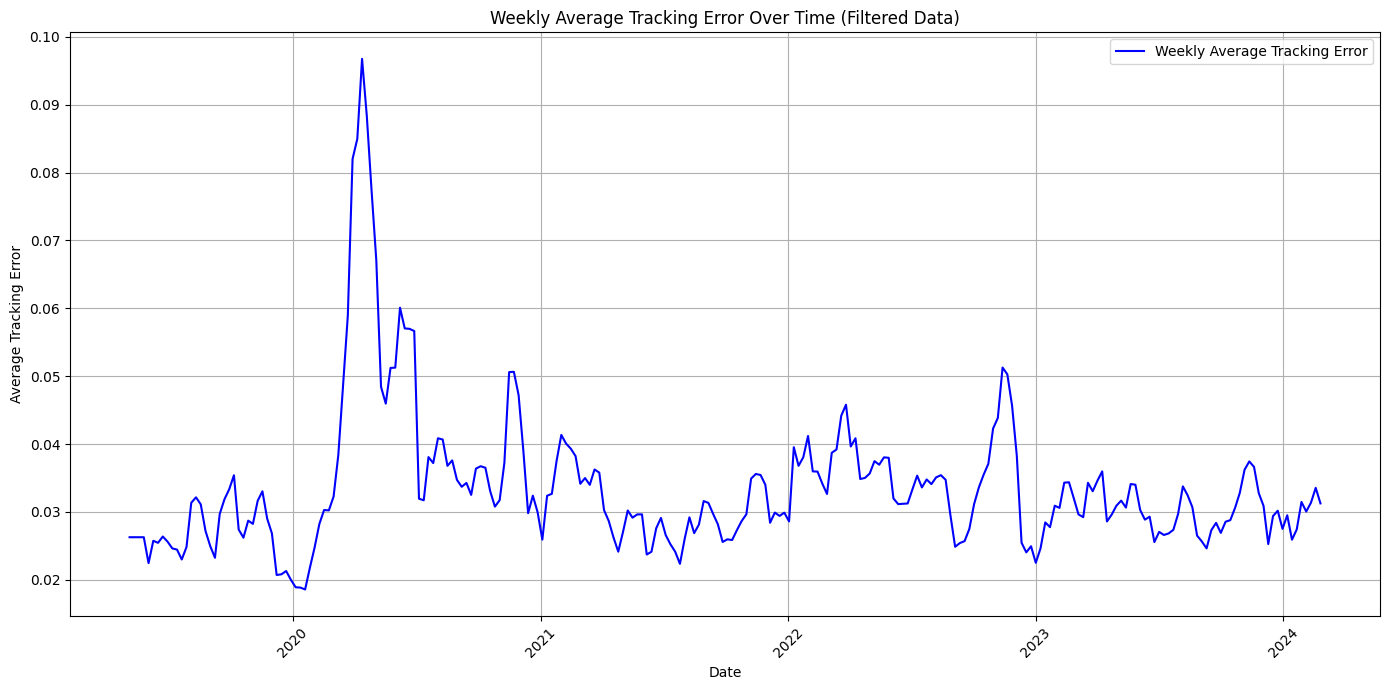

In [17]:
# Resample to weekly frequency, calculating the mean of 'Rolling Tracking Error' for each week
weekly_avg_tracking_error_filtered = filtered_data['Rolling Tracking Error'].resample('W').mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(weekly_avg_tracking_error_filtered.index, weekly_avg_tracking_error_filtered, label='Weekly Average Tracking Error', color='blue')

# Setting the x-axis major locator to years and formatter to display only the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Average Tracking Error')
plt.title('Weekly Average Tracking Error Over Time (Filtered Data)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


In [18]:
filtered_data.reset_index(inplace=True)


In [19]:
earliest_dates_after_removal = filtered_data.groupby('Ticker')['Date'].min()
print(earliest_dates_after_removal)


Ticker
A.N       2019-04-29
AAL.OQ    2019-04-29
AAPL.OQ   2019-04-29
ABBV.N    2019-04-29
ABT.N     2019-04-29
             ...    
YUM.N     2019-04-29
ZBH.N     2019-04-29
ZBRA.OQ   2019-04-29
ZION.OQ   2019-04-29
ZTS.N     2019-04-29
Name: Date, Length: 492, dtype: datetime64[ns]


In [20]:
data_points_per_ticker = filtered_data.groupby('Ticker').size()
print("Data points per ticker:\n", data_points_per_ticker)

Data points per ticker:
 Ticker
A.N        252
AAL.OQ     252
AAPL.OQ    252
ABBV.N     252
ABT.N      252
          ... 
YUM.N      252
ZBH.N      252
ZBRA.OQ    252
ZION.OQ    252
ZTS.N      252
Length: 492, dtype: int64


In [21]:
summary_statistics = filtered_data.describe()
print("Summary statistics:\n", summary_statistics)

Summary statistics:
          Close Price        Volume       PE Ratio  Weekly Return  \
count  123984.000000  1.239840e+05  114486.000000  123984.000000   
mean      160.223597  1.572703e+06      45.436608       0.002840   
std       284.068203  3.797027e+06     229.188657       0.051298   
min         3.520000  0.000000e+00       1.435796      -0.610145   
25%        54.850000  2.957522e+05      15.806082      -0.021798   
50%        99.210000  6.445640e+05      24.645918       0.002799   
75%       184.032500  1.465412e+06      37.633096       0.026644   
max      7584.750000  3.008869e+08   18187.122736       0.782480   

       Weekly Return_SPY  Differential Return  Rolling Tracking Error  \
count      123984.000000        123984.000000           123984.000000   
mean            0.002573             0.000267                0.033499   
std             0.027924             0.041314                0.024757   
min            -0.150453            -0.521260                0.000418   
2

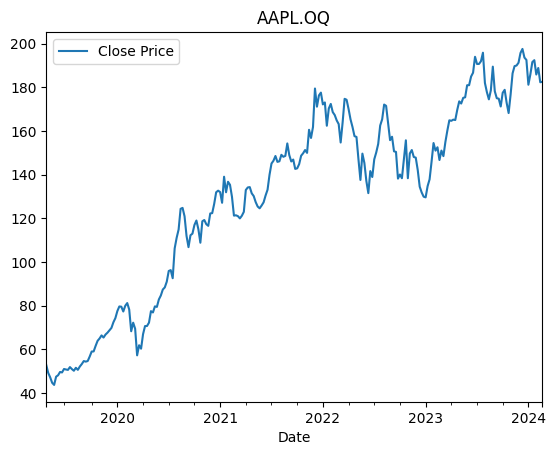

In [22]:
ticker_to_plot = 'AAPL.OQ'
filtered_data[filtered_data['Ticker'] == ticker_to_plot].plot(x='Date', y='Close Price', title=ticker_to_plot)
plt.show()


In [23]:
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
filtered_data.sort_values(by='Date', inplace=True)

# Save 'Date' information for later plotting
plotting_dates = filtered_data['Date'].copy()


In [24]:
ticker_series = filtered_data['Ticker'].copy()

In [25]:
null_values_per_variable = filtered_data.isnull().sum()

print("Null values per variable:\n", null_values_per_variable)


Null values per variable:
 Date                           0
Ticker                         0
Close Price                    0
Volume                         0
PE Ratio                    9498
Weekly Return                  0
Weekly Return_SPY              0
Differential Return            0
Rolling Tracking Error         0
Lagged_1W_Return             492
Lagged_4W_Return            1968
Historical_Volatility_4w       4
RSI_2w                         1
RSI_4w                         3
RSI_12w                       11
dtype: int64


In [26]:
imputer = SimpleImputer(strategy='median')

columns_to_impute = ['Close Price', 'PE Ratio','Lagged_1W_Return','Lagged_4W_Return','Historical_Volatility_4w', 'RSI_2w', 'RSI_4w', 'RSI_12w']

filtered_data[columns_to_impute] = imputer.fit_transform(filtered_data[columns_to_impute])

print("Null values per variable after imputation:\n", filtered_data[columns_to_impute].isnull().sum())


Null values per variable after imputation:
 Close Price                 0
PE Ratio                    0
Lagged_1W_Return            0
Lagged_4W_Return            0
Historical_Volatility_4w    0
RSI_2w                      0
RSI_4w                      0
RSI_12w                     0
dtype: int64


In [27]:
non_null_values_per_variable_after_imputation = filtered_data.count()


print("Count of non-null values per variable after imputation:\n", non_null_values_per_variable_after_imputation)


Count of non-null values per variable after imputation:
 Date                        123984
Ticker                      123984
Close Price                 123984
Volume                      123984
PE Ratio                    123984
Weekly Return               123984
Weekly Return_SPY           123984
Differential Return         123984
Rolling Tracking Error      123984
Lagged_1W_Return            123984
Lagged_4W_Return            123984
Historical_Volatility_4w    123984
RSI_2w                      123984
RSI_4w                      123984
RSI_12w                     123984
dtype: int64


In [28]:
filtered_data.head()

,Date,Ticker,Close Price,Volume,PE Ratio,Weekly Return,Weekly Return_SPY,Differential Return,Rolling Tracking Error,Lagged_1W_Return,Lagged_4W_Return,Historical_Volatility_4w,RSI_2w,RSI_4w,RSI_12w
0,2019-04-29,A.N,79.29,359454,22.104515,0.024154,0.002113,0.022041,0.051840,0.002726,0.002713,0.245723,57.370518,55.313351,53.637441
75096,2019-04-29,MHK.N,139.09,103098,11.728684,0.095197,0.002113,0.093084,0.042621,0.002726,0.002713,4.350401,100.000000,95.906832,93.999459
74844,2019-04-29,MGM.N,25.99,2655052,32.681547,-0.081950,0.002113,-0.084063,0.046401,0.002726,0.002713,10.567448,2.284800,3.310873,25.541381
74592,2019-04-29,META.OQ,195.47,4605033,29.030514,0.020784,0.002113,0.018671,0.015808,0.002726,0.002713,3.677473,100.000000,100.000000,96.124140
74340,2019-04-29,MET.N,48.00,1563015,9.726858,0.064302,0.002113,0.062188,0.027724,0.002726,0.002713,2.065826,3.211716,2.967007,20.782852


In [29]:
summary_statistics = filtered_data.describe()
print("Summary statistics:\n", summary_statistics)

Summary statistics:
          Close Price        Volume       PE Ratio  Weekly Return  \
count  123984.000000  1.239840e+05  123984.000000  123984.000000   
mean      160.223597  1.572703e+06      43.843903       0.002840   
std       284.068203  3.797027e+06     220.304411       0.051298   
min         3.520000  0.000000e+00       1.435796      -0.610145   
25%        54.850000  2.957522e+05      16.520851      -0.021798   
50%        99.210000  6.445640e+05      24.645918       0.002799   
75%       184.032500  1.465412e+06      35.928005       0.026644   
max      7584.750000  3.008869e+08   18187.122736       0.782480   

       Weekly Return_SPY  Differential Return  Rolling Tracking Error  \
count      123984.000000        123984.000000           123984.000000   
mean            0.002573             0.000267                0.033499   
std             0.027924             0.041314                0.024757   
min            -0.150453            -0.521260                0.000418   
2

In [30]:
plotting_dates = filtered_data.index.to_series()

filtered_data.reset_index(inplace=True)

if 'index' in filtered_data.columns:
    filtered_data.drop(columns=['index'], inplace=True)

# Sorting dataset by date to keep chronological order
filtered_data.sort_values(by='Date', inplace=True)

total_observations = len(filtered_data)
split_index = int(total_observations * 0.8)
plotting_dates_train = plotting_dates.iloc[:split_index]
plotting_dates_test = plotting_dates.iloc[split_index:]


train_data = filtered_data.iloc[:split_index]
test_data = filtered_data.iloc[split_index:]

X_train = train_data.drop(['Date', 'Ticker', 'Rolling Tracking Error','Weekly Return_SPY'], axis=1, errors='ignore')
y_train = train_data['Rolling Tracking Error']
X_test = test_data.drop(['Date', 'Ticker', 'Rolling Tracking Error','Weekly Return_SPY'], axis=1, errors='ignore')
y_test = test_data['Rolling Tracking Error']



# Reattaching 'Date' to y_train and y_test
y_train.index = plotting_dates.iloc[:len(y_train)].values
y_test.index = plotting_dates.iloc[-len(y_test):].values
y_train.index = pd.to_datetime(plotting_dates_train)
y_test.index = pd.to_datetime(plotting_dates_test)


plotting_dates_train = train_data['Date']
plotting_dates_test = test_data['Date']

In [31]:
filtered_data = filtered_data.drop('Date', axis=1)


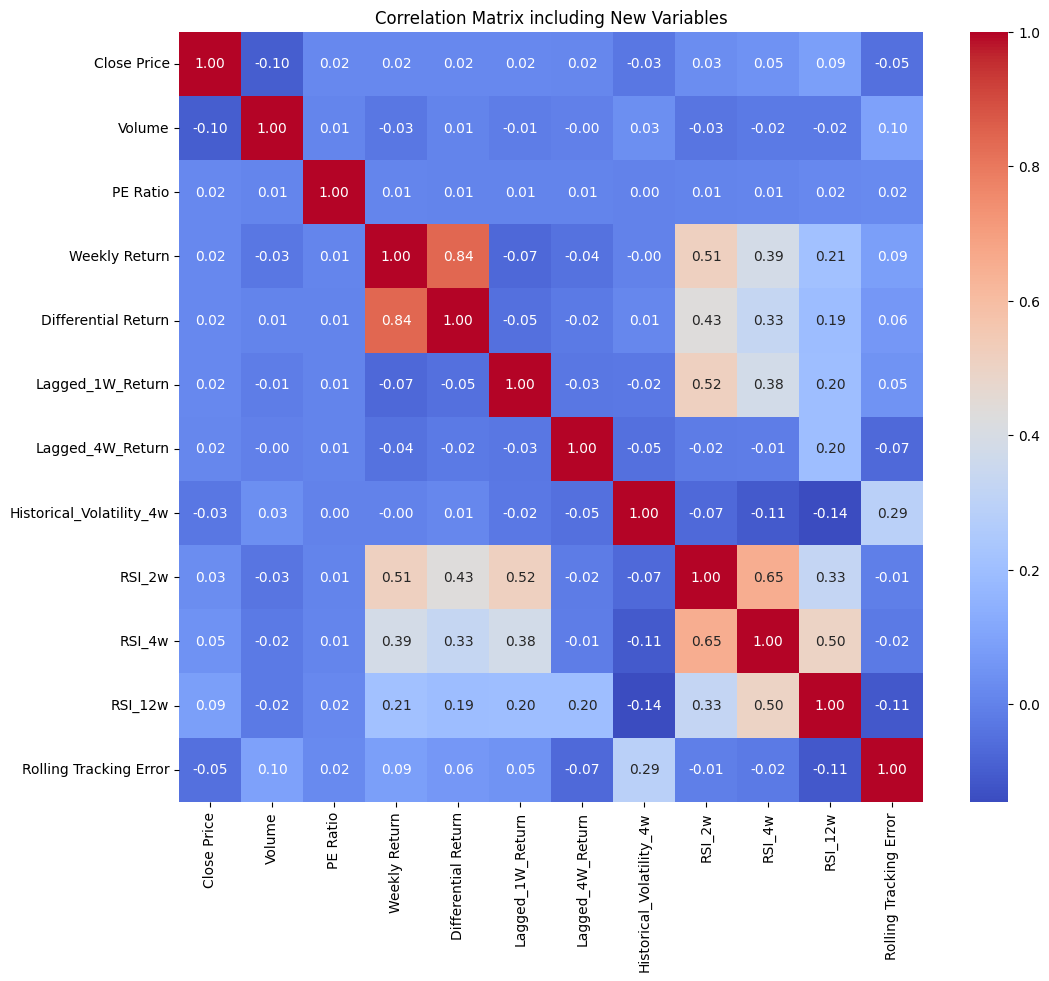

In [32]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Add the target variable if you want to see its correlation with the features
numeric_cols.append('Rolling Tracking Error')

correlation_matrix = filtered_data[numeric_cols].corr()

# Plotting the updated correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix including New Variables')
plt.show()



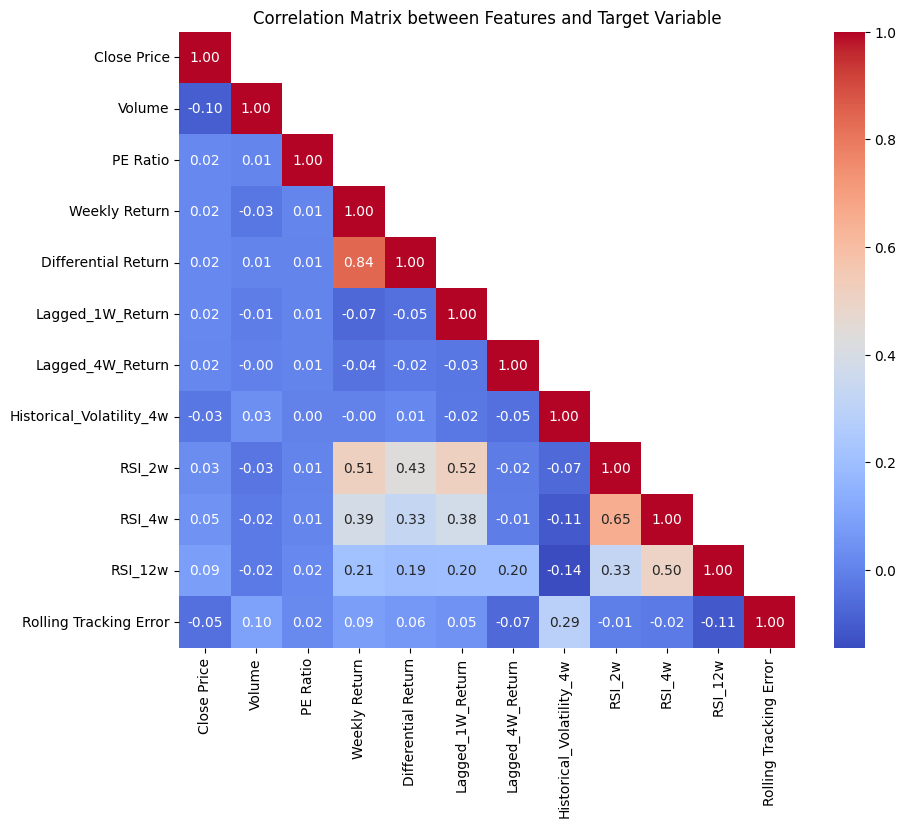

In [33]:
correlation_matrix = filtered_data[numeric_cols].corr()

# Creating a mask for the upper triangle, excluding the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)


plt.figure(figsize=(10, 8))


sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

plt.title('Correlation Matrix between Features and Target Variable')
plt.show()


In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


X = filtered_data.drop(['Ticker', 'Rolling Tracking Error', 'Weekly Return_SPY'], axis=1)
y = filtered_data['Rolling Tracking Error']


rf_model = RandomForestRegressor(
    n_estimators=300,
    criterion='friedman_mse',
    max_depth=20,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42  # Ensures reproducibility
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100


print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")
print(f"Test MAE: {mae}")
print(f"Test MAPE: {mape}%")



Test RMSE: 0.008528086034305533
Test R2: 0.792585293472083
Test MAE: 0.006293748125302838
Test MAPE: 30.49477042537947%


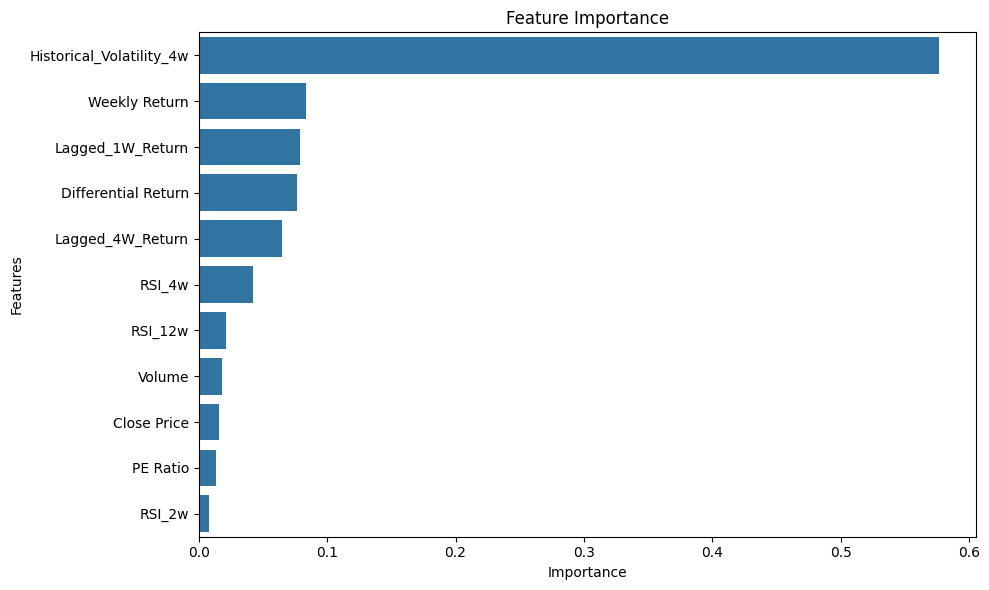

Feature Importance:
Historical_Volatility_4w    0.576966
Weekly Return               0.083773
Lagged_1W_Return            0.079037
Differential Return         0.076428
Lagged_4W_Return            0.064462
RSI_4w                      0.042262
RSI_12w                     0.021546
Volume                      0.018398
Close Price                 0.015514
PE Ratio                    0.013323
RSI_2w                      0.008291
dtype: float64


In [35]:
feature_names = X_train.columns

feature_importance = rf_model.feature_importances_

importances = pd.Series(data=feature_importance, index=feature_names)

sorted_importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances.values, y=sorted_importances.index)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

print("Feature Importance:")
print(sorted_importances)


In [36]:
print(f"Size of y_test: {len(y_test)}")
print(f"Size of y_pred: {len(y_pred)}")

assert len(y_test) == len(y_pred), "The lengths of y_test and y_pred don't match."


Size of y_test: 24797
Size of y_pred: 24797


In [37]:
filtered_data.reset_index(inplace=True)

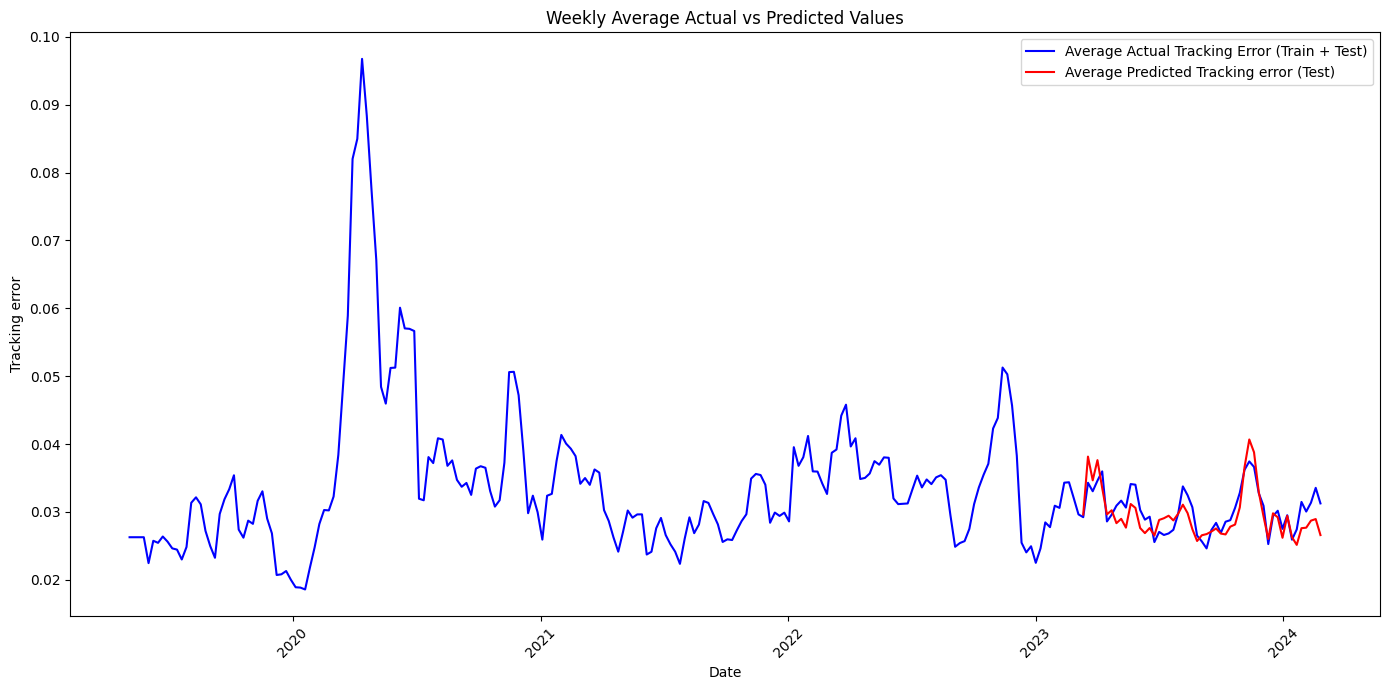

In [38]:
plotting_dates_train_dt = pd.to_datetime(plotting_dates_train)
plotting_dates_test_dt = pd.to_datetime(plotting_dates_test)

# Combine actual and predicted values with correct dates
combined_actuals = pd.concat([
    pd.Series(y_train.values, index=plotting_dates_train_dt),
    pd.Series(y_test.values, index=plotting_dates_test_dt)
])

predicted_series = pd.Series(y_pred, index=plotting_dates_test_dt)

# Resample and calculate weekly averages
weekly_avg_actuals = combined_actuals.resample('W').mean()
weekly_avg_predicted = predicted_series.resample('W').mean()


fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(weekly_avg_actuals.index, weekly_avg_actuals, label='Average Actual Tracking Error (Train + Test)', color='blue')
ax.plot(weekly_avg_predicted.index, weekly_avg_predicted, label='Average Predicted Tracking error (Test)', linestyle='-', color='red')


ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

ax.set_title('Weekly Average Actual vs Predicted Values')
ax.set_xlabel('Date')
ax.set_ylabel('Tracking error')
ax.legend()
plt.tight_layout()
plt.show()



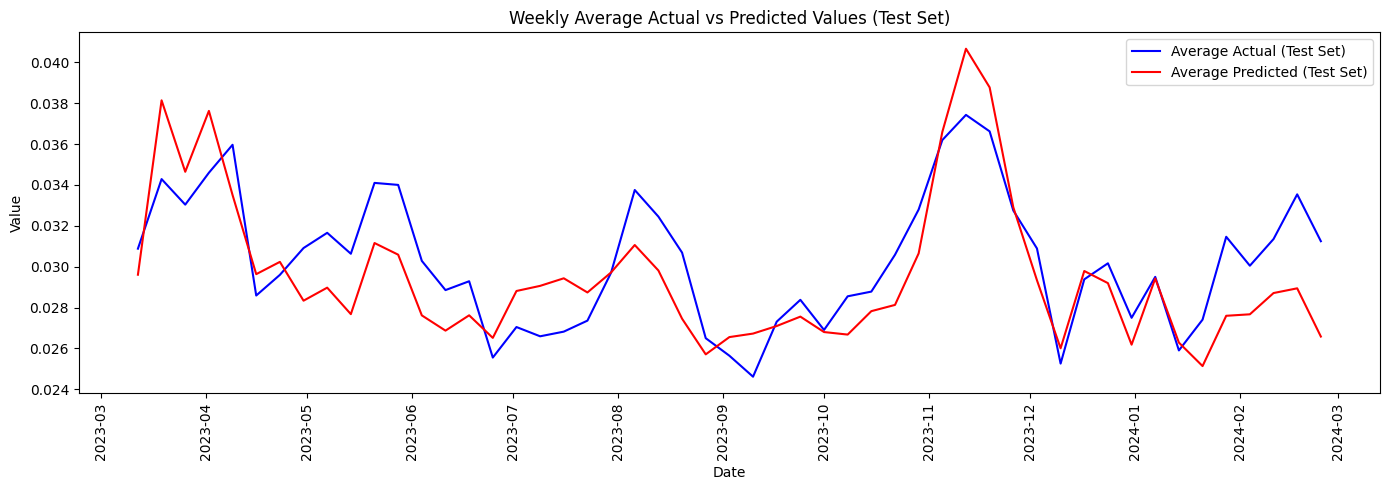

In [39]:
plotting_dates_test_dt = pd.to_datetime(plotting_dates_test)

# Creating Series for test actual and predicted values
test_actual_series = pd.Series(y_test.values, index=plotting_dates_test_dt)
predicted_series = pd.Series(y_pred, index=plotting_dates_test_dt)

# Resample and calculate weekly averages
weekly_avg_test_actuals = test_actual_series.resample('W').mean()
weekly_avg_predicted = predicted_series.resample('W').mean()


fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(weekly_avg_test_actuals.index, weekly_avg_test_actuals, label='Average Actual (Test Set)', color='blue')
ax.plot(weekly_avg_predicted.index, weekly_avg_predicted, label='Average Predicted (Test Set)', linestyle='-', color='red')


ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=90)

ax.set_title('Weekly Average Actual vs Predicted Values (Test Set)')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.legend()
plt.tight_layout()
plt.show()

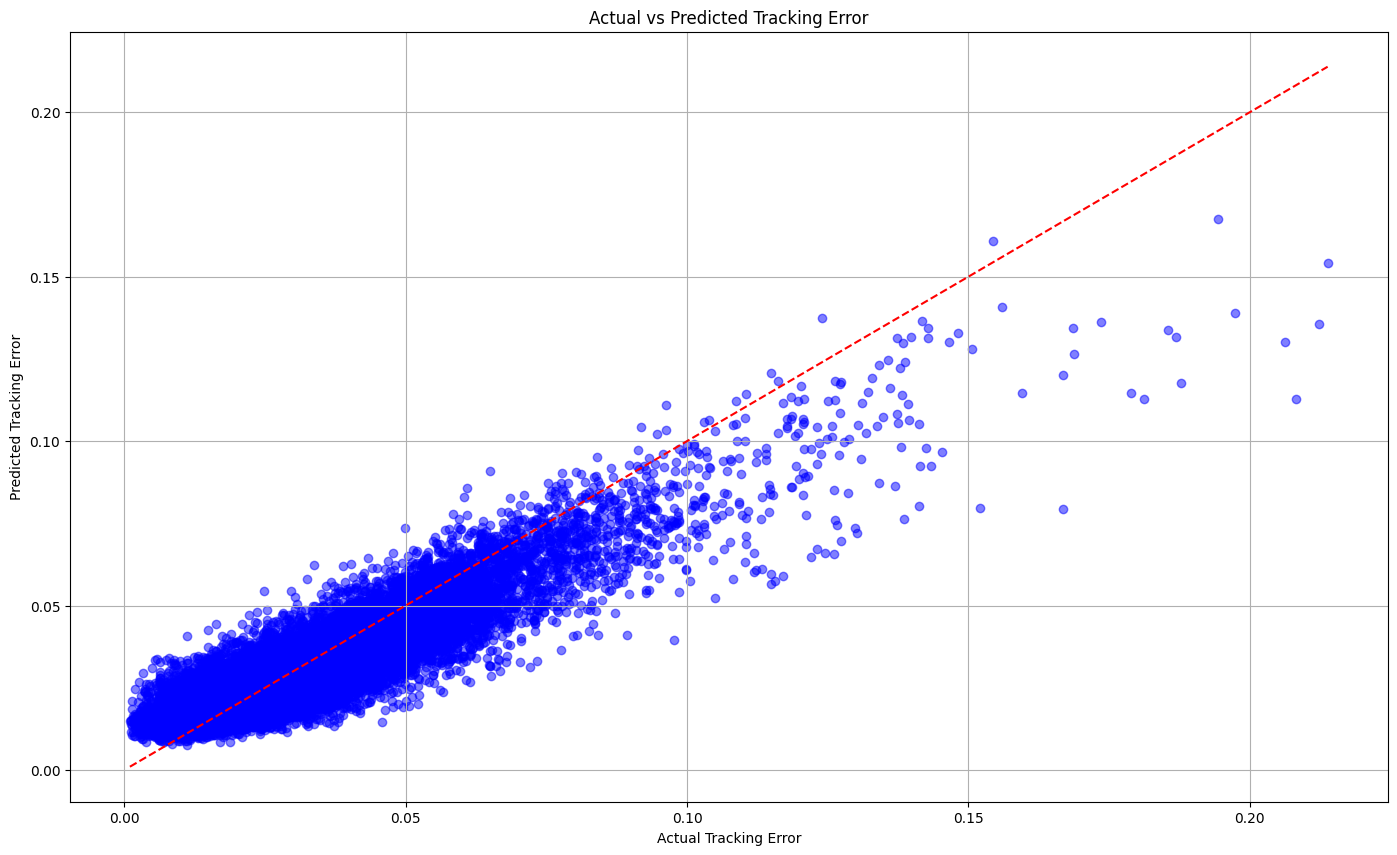

In [40]:
plt.figure(figsize=(17, 10))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Tracking Error')
plt.xlabel('Actual Tracking Error')
plt.ylabel('Predicted Tracking Error')
plt.grid(True)
plt.show()



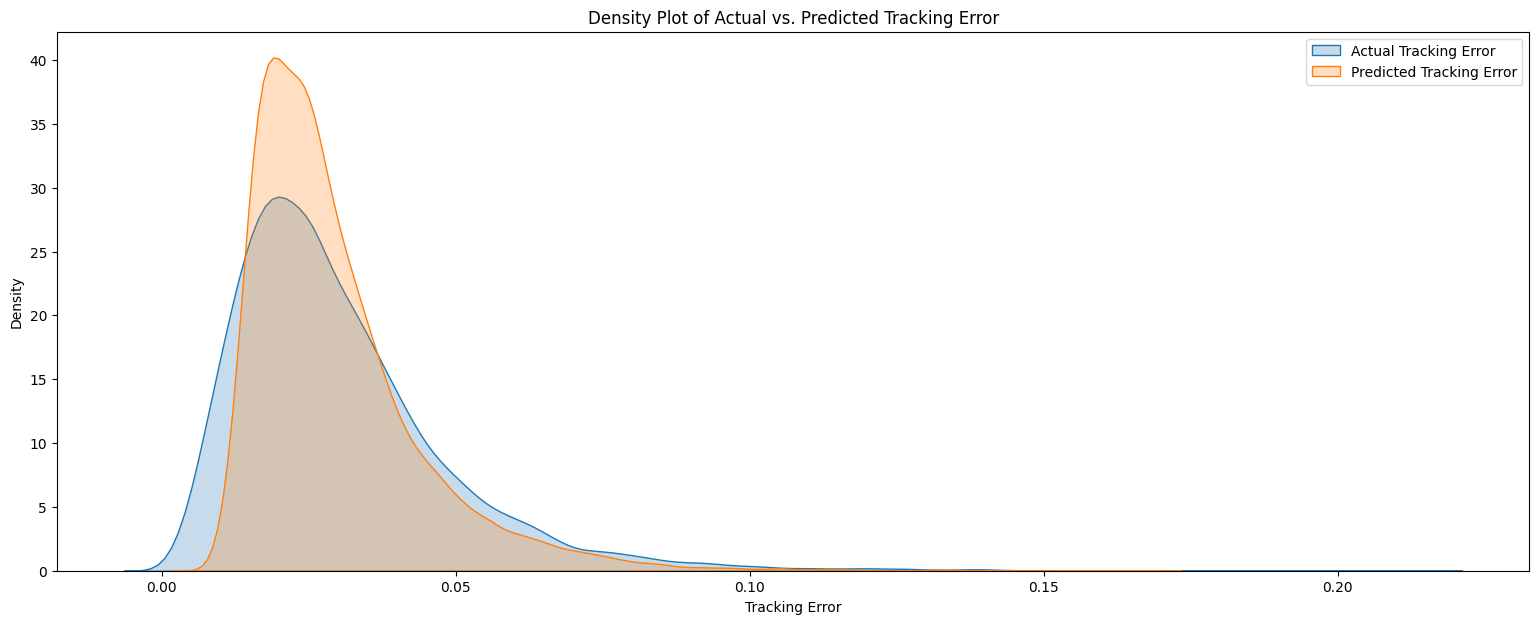

In [41]:
actual = y_test
predicted = y_pred

plt.figure(figsize=(19, 7))


sns.kdeplot(actual, label='Actual Tracking Error', fill=True)


sns.kdeplot(predicted, label='Predicted Tracking Error', fill=True)

plt.title('Density Plot of Actual vs. Predicted Tracking Error')
plt.xlabel('Tracking Error')
plt.ylabel('Density')
plt.legend()

plt.show()

In [42]:
from sklearn.model_selection import TimeSeriesSplit

# Number of splits for TimeSeriesSplit

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
model = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
scores = {'rmse': [], 'mae': [], 'mape': [], 'r2': []}
weekly_averages_per_fold = []

for fold, (train_index, test_index) in enumerate(tscv.split(X), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate and store scores
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    r2 = r2_score(y_test, y_pred)
    scores['rmse'].append(rmse)
    scores['mae'].append(mae)
    scores['mape'].append(mape)
    scores['r2'].append(r2)


    print(f"Fold {fold}: RMSE={rmse}, MAE={mae}, MAPE={mape}%, R2={r2}")


    dates_test = plotting_dates.iloc[test_index]
    actuals = pd.Series(y_test.values, index=pd.to_datetime(dates_test))
    predictions = pd.Series(y_pred, index=pd.to_datetime(dates_test))
    weekly_averages_per_fold.append((actuals.resample('W').mean(), predictions.resample('W').mean()))


print("\nAverage Scores Across All Folds:")
for metric, values in scores.items():
    print(f"Average {metric.upper()}: {np.mean(values)}")


Fold 1: RMSE=0.030318076013848328, MAE=0.01915982179575734, MAPE=56.26240028710241%, R2=0.3515833740413976
Fold 2: RMSE=0.008903033443507699, MAE=0.006486324925088645, MAPE=30.980514303920582%, R2=0.7966665526041202
Fold 3: RMSE=0.012566217767371931, MAE=0.009472955873366851, MAPE=40.858846525927%, R2=0.6613639387791941
Fold 4: RMSE=0.011273255742343348, MAE=0.008704350833447038, MAPE=43.28155675074929%, R2=0.7192347719245934
Fold 5: RMSE=0.008381449503820892, MAE=0.006193192032275245, MAPE=30.116567117141617%, R2=0.7960525248241558

Average Scores Across All Folds:
Average RMSE: 0.014288406494178438
Average MAE: 0.010003329091987024
Average MAPE: 40.299976996968184
Average R2: 0.6649802324346922


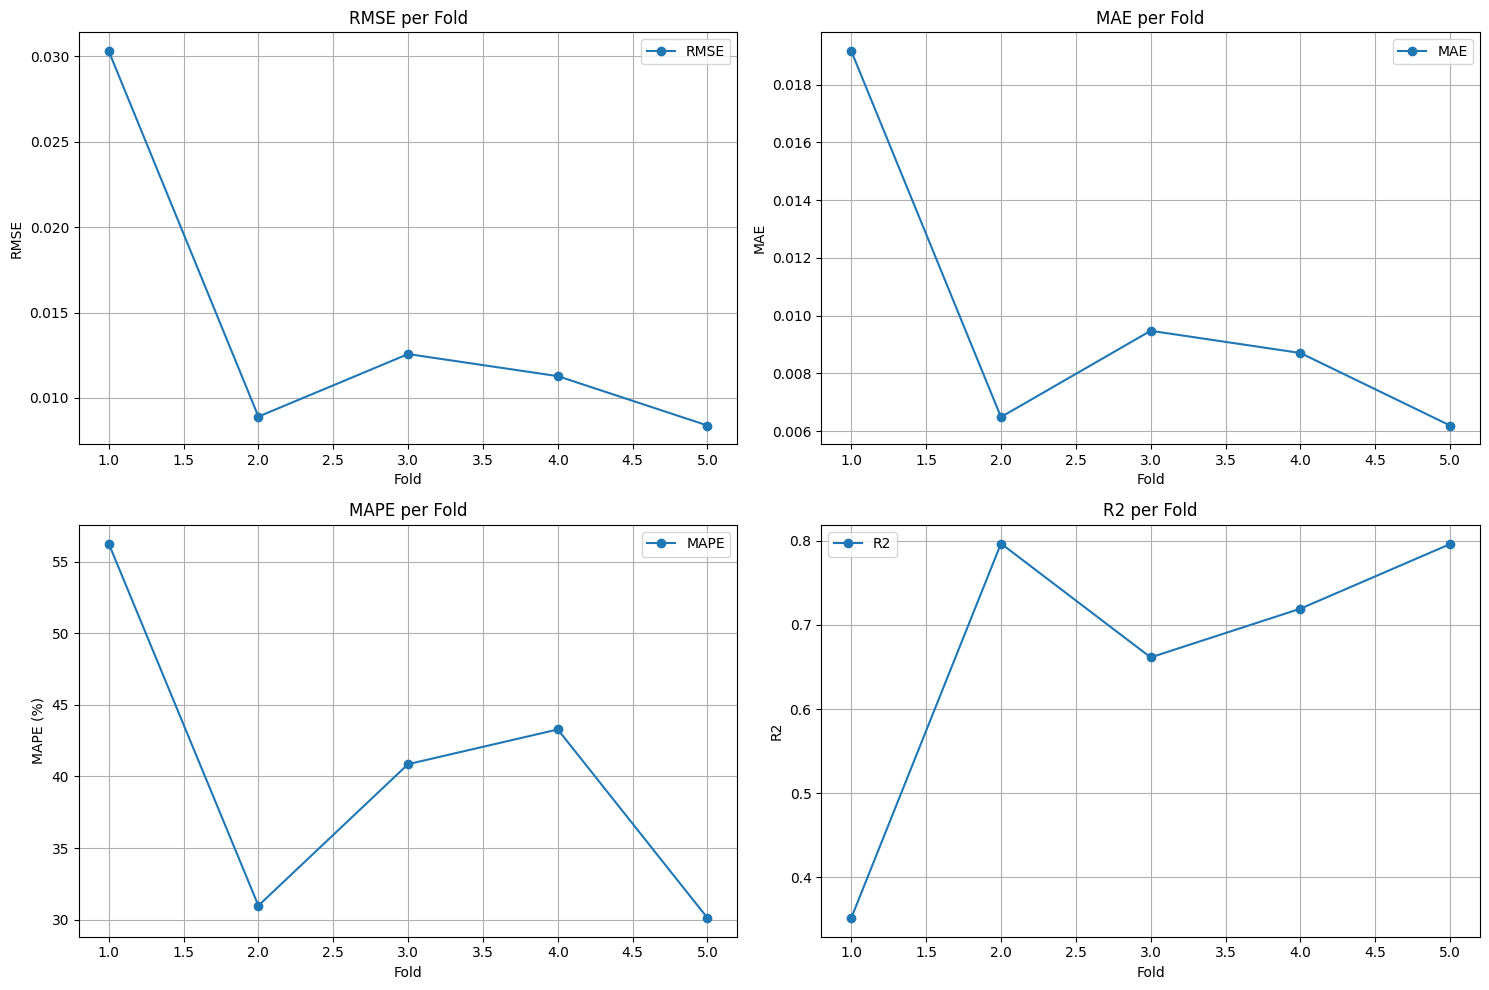

In [43]:
folds = np.arange(1, 6)
rmse_scores = [0.030318076013848328, 0.008903033443507699, 0.012566217767371931, 0.011273255742343348, 0.008381449503820892]
mae_scores = [0.01915982179575734, 0.006486324925088645, 0.009472955873366851, 0.008704350833447038, 0.006193192032275245]
mape_scores = [56.26240028710241, 30.980514303920582, 40.858846525927, 43.28155675074929, 30.116567117141617]
r2_scores = [0.3515833740413976, 0.7966665526041202, 0.6613639387791941, 0.7192347719245934, 0.7960525248241558]


fig, axs = plt.subplots(2, 2, figsize=(15, 10))


axs[0, 0].plot(folds, rmse_scores, '-o', label='RMSE')
axs[0, 0].set_title('RMSE per Fold')
axs[0, 0].set_xlabel('Fold')
axs[0, 0].set_ylabel('RMSE')
axs[0, 0].legend()
axs[0, 0].grid(True)


axs[0, 1].plot(folds, mae_scores, '-o', label='MAE')
axs[0, 1].set_title('MAE per Fold')
axs[0, 1].set_xlabel('Fold')
axs[0, 1].set_ylabel('MAE')
axs[0, 1].legend()
axs[0, 1].grid(True)


axs[1, 0].plot(folds, mape_scores, '-o', label='MAPE')
axs[1, 0].set_title('MAPE per Fold')
axs[1, 0].set_xlabel('Fold')
axs[1, 0].set_ylabel('MAPE (%)')
axs[1, 0].legend()
axs[1, 0].grid(True)


axs[1, 1].plot(folds, r2_scores, '-o', label='R2')
axs[1, 1].set_title('R2 per Fold')
axs[1, 1].set_xlabel('Fold')
axs[1, 1].set_ylabel('R2')
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


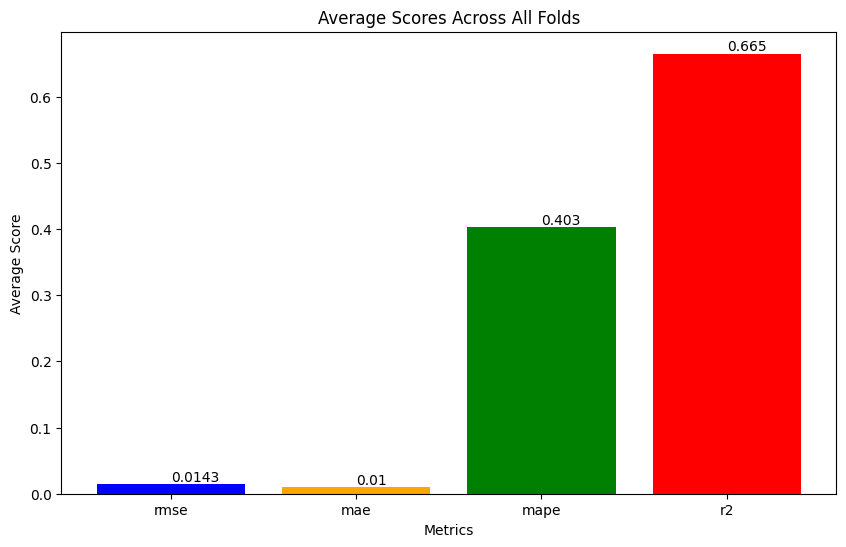

In [44]:
scores = {
    'rmse': [0.030318076013848328, 0.008903033443507699, 0.012566217767371931, 0.011273255742343348, 0.008381449503820892],
    'mae': [0.01915982179575734, 0.006486324925088645, 0.009472955873366851, 0.008704350833447038, 0.006193192032275245],
    'mape': [0.5626240028710241, 0.30980514303920582, 0.40858846525927, 0.4328155675074929, 0.30116567117141617],
    'r2': [0.3515833740413976, 0.7966665526041202, 0.6613639387791941, 0.7192347719245934, 0.7960525248241558]
}


average_scores = {metric: sum(values) / len(values) for metric, values in scores.items()}


metrics = list(average_scores.keys())
averages = list(average_scores.values())


plt.figure(figsize=(10, 6))
bar_plot = plt.bar(metrics, averages, color=['blue', 'orange', 'green', 'red'])

plt.xlabel('Metrics')
plt.ylabel('Average Score')
plt.title('Average Scores Across All Folds')


for bar in bar_plot:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval,4), va='bottom')

plt.show()


In [68]:
predicted_tracking_errors = rf_model.predict(X_test)
test_data.loc[X_test.index, 'predicted_tracking_error'] = predicted_tracking_errors

average_predicted_errors_per_stock = test_data.groupby('Ticker')['predicted_tracking_error'].mean()

selected_stocks_symbols = average_predicted_errors_per_stock[average_predicted_errors_per_stock < 0.033499].index
selected_stocks = test_data[test_data['Ticker'].isin(selected_stocks_symbols)]

average_return_selected_stocks = selected_stocks.groupby('Ticker')['Weekly Return'].mean().mean()
average_return_sp500 = test_data['Weekly Return_SPY'].mean()

performance_comparison = {
    "Average Weekly Return of Selected Tickers": average_return_selected_stocks,
    "Average Weekly Return of S&P 500 Index": average_return_sp500
}
print(performance_comparison)

average_actual_tracking_error_test_set = test_data.groupby('Ticker')['Rolling Tracking Error'].mean().mean()
average_actual_tracking_error_selected_stocks = selected_stocks.groupby('Ticker')['Rolling Tracking Error'].mean().mean()

tracking_error_comparison = {
    "Average Weekly Actual Tracking Error - Test Set": average_actual_tracking_error_test_set,
    "Average Weekly Actual Tracking Error - Selected Tickers": average_actual_tracking_error_selected_stocks
}
print(tracking_error_comparison)




{'Average Weekly Return of Selected Tickers': 0.003080859972079459, 'Average Weekly Return of S&P 500 Index': 0.0052337506938705276}
{'Average Weekly Actual Tracking Error - Test Set': 0.030257973790319654, 'Average Weekly Actual Tracking Error - Selected Tickers': 0.02608536985235387}


In [69]:
percentage_difference_tracking_error = ((average_actual_tracking_error_selected_stocks - average_actual_tracking_error_test_set) / average_actual_tracking_error_test_set) * 100

print(f"Percentage Difference in Average Actual Tracking Error: {percentage_difference_tracking_error:.2f}%")


Percentage Difference in Average Actual Tracking Error: -13.79%


In [70]:
num_stocks_before_selection = test_data['Ticker'].nunique()

num_stocks_after_selection = selected_stocks['Ticker'].nunique()

print(f"Number of stocks before selection: {num_stocks_before_selection}")
print(f"Number of stocks after selection: {num_stocks_after_selection}")


Number of stocks before selection: 492
Number of stocks after selection: 379


In [71]:
average_tracking_errors_per_stock = test_data.groupby('Ticker')['Rolling Tracking Error'].mean()

top_20_stocks = average_tracking_errors_per_stock.nsmallest(20).index

selected_top_20_stocks = test_data[test_data['Ticker'].isin(top_20_stocks)]

average_return_top_20_stocks = selected_top_20_stocks.groupby('Ticker')['Weekly Return'].mean().mean()
print(f"Average Weekly Return of Top 20 Selected Stocks: {average_return_top_20_stocks}")

average_return_sp500 = test_data['Weekly Return_SPY'].mean()
print(f"Average Weekly Return of S&P 500 Index: {average_return_sp500}")

average_tracking_error_top_20_stocks = selected_top_20_stocks.groupby('Ticker')['Rolling Tracking Error'].mean().mean()
print(f"Average Weekly Actual Tracking Error - Top 20 Selected Stocks: {average_tracking_error_top_20_stocks}")

num_stocks_before_selection = test_data['Ticker'].nunique()
num_stocks_after_selection = selected_top_20_stocks['Ticker'].nunique()
print(f"Number of stocks before selection: {num_stocks_before_selection}")
print(f"Number of stocks after selection: {num_stocks_after_selection}")


Average Weekly Return of Top 20 Selected Stocks: 0.005002964839351023
Average Weekly Return of S&P 500 Index: 0.0052337506938705276
Average Weekly Actual Tracking Error - Top 20 Selected Stocks: 0.0159691720365926
Number of stocks before selection: 492
Number of stocks after selection: 20


In [72]:
percentage_difference_tracking_error_top_20 = ((average_tracking_error_top_20_stocks - average_actual_tracking_error_test_set) / average_actual_tracking_error_test_set) * 100

print(f"Percentage Difference in Average Actual Tracking Error (Top 20 vs. Test Set): {percentage_difference_tracking_error_top_20:.2f}%")


Percentage Difference in Average Actual Tracking Error (Top 20 vs. Test Set): -47.22%


In [73]:
print("Selected Top 20 Stocks with the Lowest Weekly Tracking Error:")
for stock in top_20_stocks:
    print(stock)

Selected Top 20 Stocks with the Lowest Weekly Tracking Error:
MA.N
V.N
TJX.N
ROP.OQ
BRKb.N
APH.N
MCO.N
MCD.N
ROST.OQ
LIN.OQ
ICE.N
VRSN.OQ
SPGI.N
ADP.OQ
HD.N
FI.N
RSG.N
YUM.N
AME.N
TMO.N
